# Analyze the results of the prediction
1. Generate the metadataset by running all cells in `create-metadataset.ipynb`
2. Run `train.py`. Make sure to use a config with the postprocessing step `VisualizationBlock`
3. Find the directory in `outputs/` that was created at the time you ran `train.py` and copy the path
4. Paste the path in the `RESULTS_PATH` variable below
5. View the plots, explore the tabels in your IDE, and view the images with the dashboard using their `tile_id`

In [5]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
RESULTS_PATH = Path('../outputs/2024-01-26/10-38-15/results.csv')

In [7]:
# Load the processed metadataset
metadataset = pd.read_csv('../data/processed/metadata.csv', index_col=0)
metadataset

,cloud,land,missing_landsat,kelp,in_train
tile_id,,,,,
JW725114,0.008294,0.142604,0.000000,0.000082,True
UX493605,0.004155,0.303135,0.000000,0.007404,True
OU500661,0.039673,0.254376,0.000000,0.000000,True
DC227980,0.009371,0.429110,0.000000,0.000000,True
SS602790,0.061763,0.837020,0.000000,0.000000,True
...,...,...,...,...,...
UT495238,0.297796,0.601306,0.296580,NaN,False
GE987629,0.307053,0.125967,0.307020,NaN,False
EN974536,0.348498,0.714710,0.348269,NaN,False


Load prediction results csv to analyze performance

In [8]:
# Load the prediction results
results = pd.read_csv(RESULTS_PATH, index_col=0)
results.head()

,sum_targets,sum_preds,intersections,dice_coef
image_key,,,,
AB841632,0.0,227.976547,0.0,0.0
CS110537,0.0,1.994417,0.0,0.0
CR788938,0.0,2.759722,0.0,0.0
CQ670511,0.0,0.555100,0.0,0.0
CQ363807,0.0,2.361273,0.0,0.0


Join the results with the metadata

In [9]:
results = metadataset.merge(results,left_index=True, right_index=True, how='inner')
results

,cloud,land,missing_landsat,kelp,in_train,sum_targets,sum_preds,intersections,dice_coef
CW933853,0.206669,0.434588,0.204882,0.000000,True,0.000000,855.431885,0.000000,0.000000
DR215333,0.000163,0.054522,0.000000,0.009396,True,1151.000000,842.740723,606.102295,0.608005
BF433443,0.000000,0.356751,0.000000,0.002367,True,290.000000,29.886486,24.794407,0.155020
AT299422,0.000506,0.133918,0.000000,0.000359,True,44.000000,4.632278,0.969721,0.039880
BQ547818,0.000098,0.034171,0.000000,0.001167,True,143.000015,339.489349,122.201103,0.506544
...,...,...,...,...,...,...,...,...,...
CZ551084,0.203804,0.148384,0.201976,0.002310,True,283.000000,945.472900,253.818726,0.413226
CQ701885,0.040318,0.096310,0.032629,0.010849,True,1329.000000,1544.383545,1073.675049,0.747325
CB110195,0.190914,0.278784,0.190547,0.000857,True,105.000000,80.894798,29.528475,0.317690
CX717130,0.153518,0.046392,0.152620,0.000000,True,0.000000,1.867857,0.000000,0.000000


In [10]:
results['union'] = results['sum_targets'] + results['sum_preds']

# Compute error
Error is roughly "how much would our score increase if we had perfect predictions for this error"
Lower is better.

In [11]:
# compute error (difference between dice if prediction would've been perfect and actual dice)
total_intersection = results['intersections'].sum()
total_union = results['union'].sum()

perfect_dice = (2 * results['sum_targets'] + 2 * (total_intersection - results['intersections'])) / ((total_union - results['sum_preds'] - results['sum_targets']) + 2 * results['sum_targets'])
all_dice = (2 * total_intersection) / (total_union)
results['perfect_dice'] = perfect_dice
results["all_dice"] = all_dice
results['error'] = perfect_dice - all_dice
results["error_per"] = results['error'] * 100
results

,cloud,land,missing_landsat,kelp,in_train,sum_targets,sum_preds,intersections,dice_coef,union,perfect_dice,all_dice,error,error_per
CW933853,0.206669,0.434588,0.204882,0.000000,True,0.000000,855.431885,0.000000,0.000000,855.431885,0.596203,0.594338,0.001865,0.186466
DR215333,0.000163,0.054522,0.000000,0.009396,True,1151.000000,842.740723,606.102295,0.608005,1993.740723,0.597649,0.594338,0.003311,0.331086
BF433443,0.000000,0.356751,0.000000,0.002367,True,290.000000,29.886486,24.794407,0.155020,319.886486,0.595711,0.594338,0.001373,0.137273
AT299422,0.000506,0.133918,0.000000,0.000359,True,44.000000,4.632278,0.969721,0.039880,48.632278,0.594567,0.594338,0.000229,0.022907
BQ547818,0.000098,0.034171,0.000000,0.001167,True,143.000015,339.489349,122.201103,0.506544,482.489365,0.594918,0.594338,0.000579,0.057947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CZ551084,0.203804,0.148384,0.201976,0.002310,True,283.000000,945.472900,253.818726,0.413226,1228.472900,0.595995,0.594338,0.001657,0.165693
CQ701885,0.040318,0.096310,0.032629,0.010849,True,1329.000000,1544.383545,1073.675049,0.747325,2873.383545,0.596675,0.594338,0.002337,0.233686
CB110195,0.190914,0.278784,0.190547,0.000857,True,105.000000,80.894798,29.528475,0.317690,185.894798,0.594838,0.594338,0.000499,0.049944
CX717130,0.153518,0.046392,0.152620,0.000000,True,0.000000,1.867857,0.000000,0.000000,1.867857,0.594342,0.594338,0.000004,0.000406


In [12]:
# Now lets filter the df on where sum_targets is larger than 0 and sort on asc dice coef

df_filter = results[results['kelp'] > 0]
print(len(results), len(df_filter))
df_filter = df_filter.sort_values(by='error', ascending=True)
df_filter.head(25)

200 119


,cloud,land,missing_landsat,kelp,in_train,sum_targets,sum_preds,intersections,dice_coef,union,perfect_dice,all_dice,error,error_per
DT556491,0.081796,0.617159,0.000416,0.000024,True,3.000000,0.962575,0.000012,0.000006,3.962575,0.594356,0.594338,0.000018,0.001751
BN224921,0.000784,0.822718,0.000000,0.000049,True,6.000000,0.657446,0.000015,0.000005,6.657446,0.594370,0.594338,0.000032,0.003226
BE965130,0.001371,0.220816,0.000000,0.000049,True,6.000000,7.406942,0.000121,0.000018,13.406942,0.594385,0.594338,0.000047,0.004693
DF832411,0.000147,0.068180,0.000000,0.000188,True,23.000000,2.455178,0.000136,0.000011,25.455178,0.594462,0.594338,0.000124,0.012353
EA786674,0.028163,0.368539,0.107322,0.000286,True,35.000000,6.721648,2.200695,0.105494,41.721648,0.594516,0.594338,0.000178,0.017837
CZ947352,0.011910,0.105665,0.000000,0.000294,True,36.000000,2.849500,0.093864,0.004832,38.849500,0.594529,0.594338,0.000190,0.019050
AT299422,0.000506,0.133918,0.000000,0.000359,True,44.000000,4.632278,0.969721,0.039880,48.632278,0.594567,0.594338,0.000229,0.022907
DN412676,0.063355,0.347739,0.309812,0.000498,True,61.000000,2.841012,0.001455,0.000046,63.841012,0.594658,0.594338,0.000320,0.031959
AW297364,0.070669,0.601241,0.000000,0.001004,True,123.000008,121.518860,70.773216,0.578877,244.518867,0.594717,0.594338,0.000379,0.037868
DE439128,0.127771,0.592661,0.000000,0.000008,True,1.000000,191.327057,0.000178,0.000002,192.327057,0.594759,0.594338,0.000421,0.042118


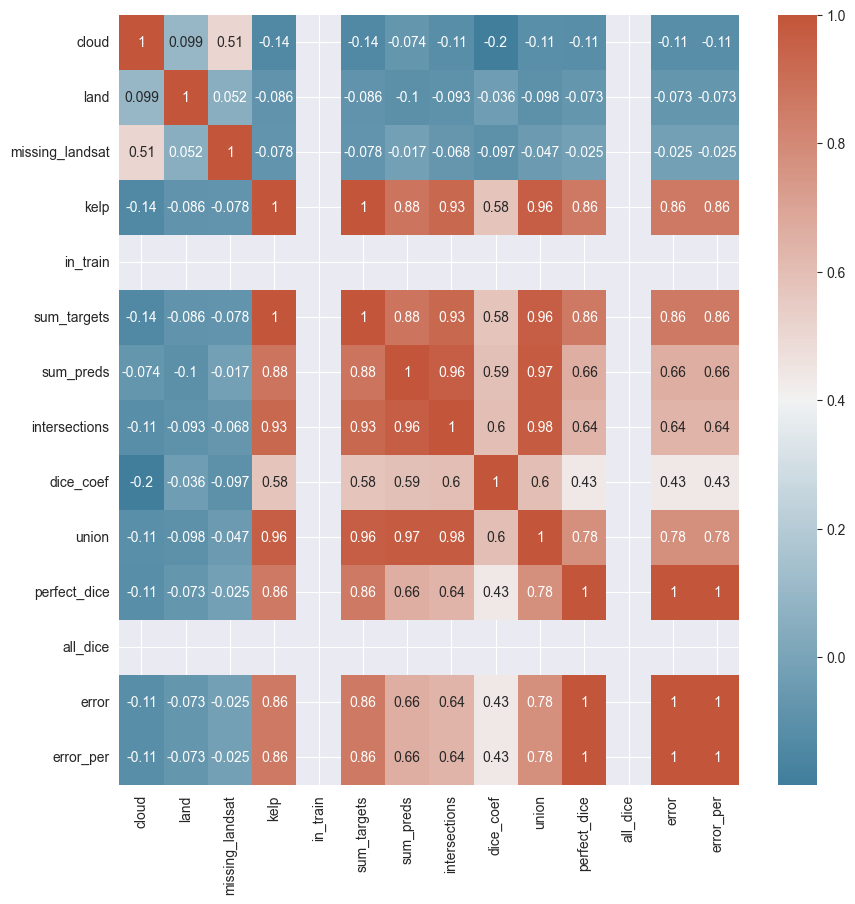

In [13]:
# Plot the correlation matrix with sns

#Use a good colormap 
cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(10,10))
corr = results.corr()
sns.heatmap(corr, annot=True, cmap=cmap, ax=ax)
plt.show()

# Plots against error

### Do we predict too much or too little kelp?


142861.4478006661 130652.00112247467
In total we predict 109.34501314430396% of the true kelp in the dataset
Kelp in dataset: 0.5332734739692844%
TP: 81279.73026830846, FP: 61581.717532357645, FN: 49372.27085416622, TN: 24330780.163208216


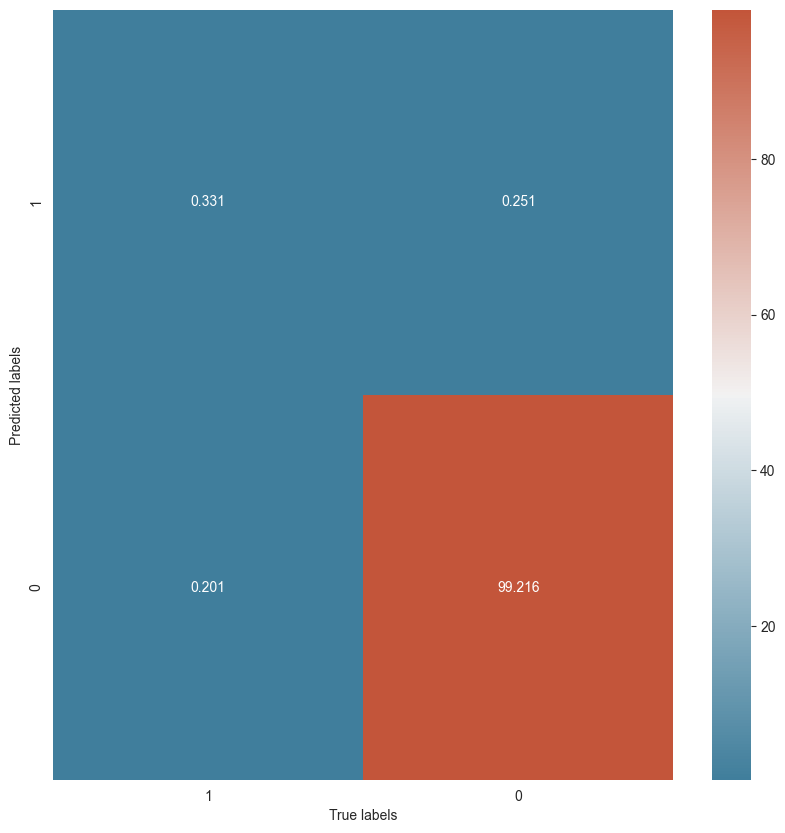

In [14]:
total_predicted = results['sum_preds'].sum()
total_actual = results['sum_targets'].sum()
print(total_predicted, total_actual)
# Print as a percentage

print(f"In total we predict {total_predicted / total_actual * 100}% of the true kelp in the dataset")
print(f"Kelp in dataset: {total_actual / (350 * 350 * len(results)) * 100}%")

results["TP"] = results["intersections"]
a = (350 * 350) - results["sum_preds"]
b = (350 * 350) - results["sum_targets"]
#Set results TN to the min(a,b)
results["TN"] = a.where(a < b, b)
results["FP"] = results["sum_preds"] - results["intersections"]
results["FN"] = results["sum_targets"] - results["intersections"]

#Print the sum of the confusion matrix with annotation f string
print(f"TP: {results['TP'].sum()}, FP: {results['FP'].sum()}, FN: {results['FN'].sum()}, TN: {results['TN'].sum()}")


# Create the confusion matrix from the results
#Print in a nice format rounded by 3 decimals
confusion_matrix = results[['TP', 'FP', 'FN', 'TN']].sum().values.reshape(2,2)
# Print the confusion matrix using seaborn in float with 3 decimals

#Print the one with percentages on the right

confusion_matrix_perc = (confusion_matrix / confusion_matrix.sum()) * 100
fig, ax = plt.subplots(figsize=(10,10))

#Name the axis correctly to the format of a heatmap with TP, FP, FN, TN

sns.heatmap(confusion_matrix_perc, annot=True, fmt='.3f', cmap=cmap)
#Add correct predictions and labels to the confusion matrix axes
# Set x axis to 0,1
ax.set_xticklabels([1,0])
ax.set_yticklabels([1,0])
ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')



plt.show()





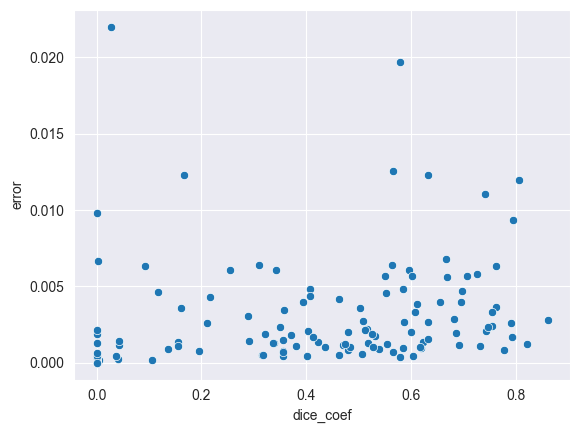

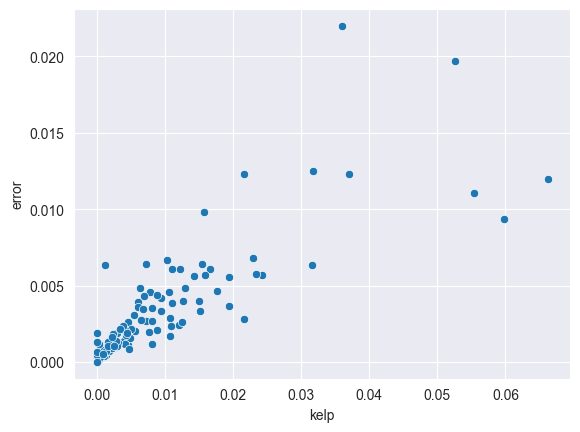

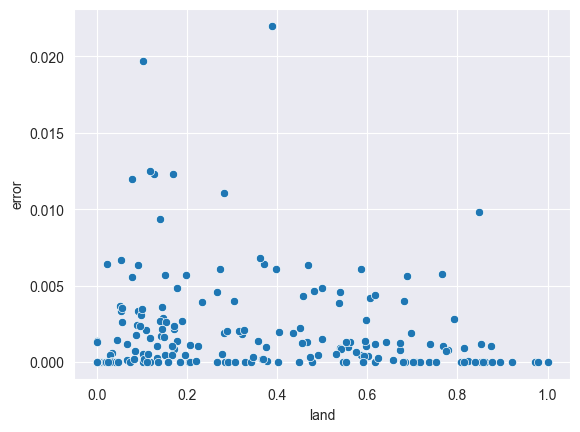

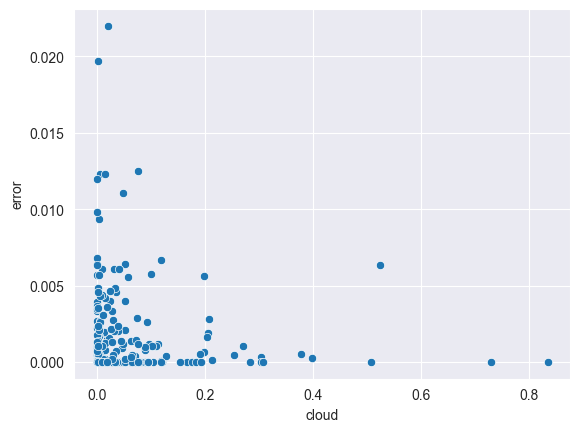

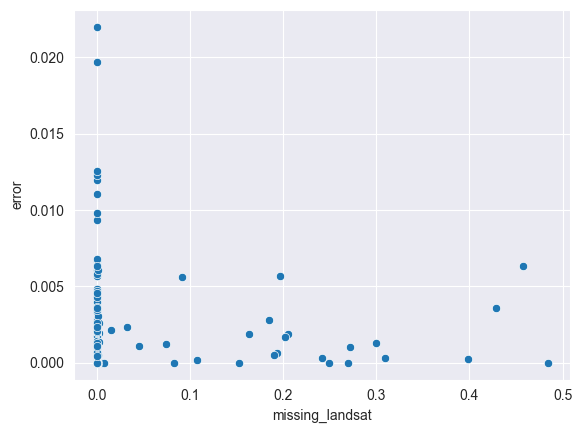

In [15]:
# Plot scatterplots of error
for col in ['dice_coef','kelp', 'land', 'cloud', 'missing_landsat']:
    sns.scatterplot(data=results, x=col, y='error')
    plt.show()

# Plots against dice coef

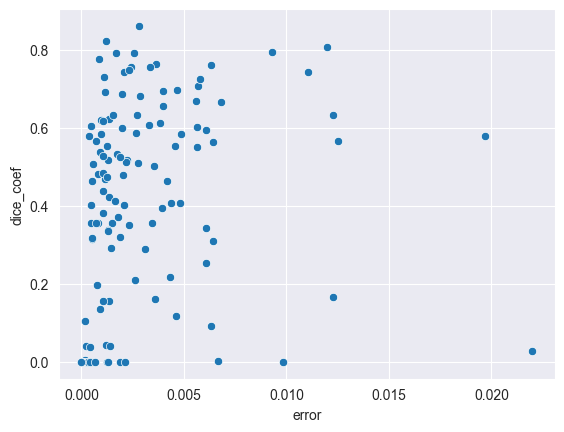

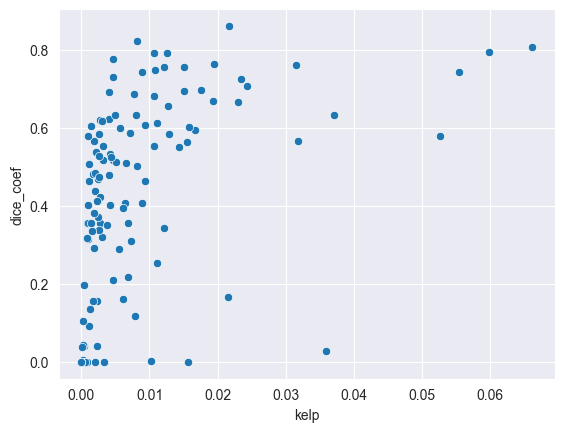

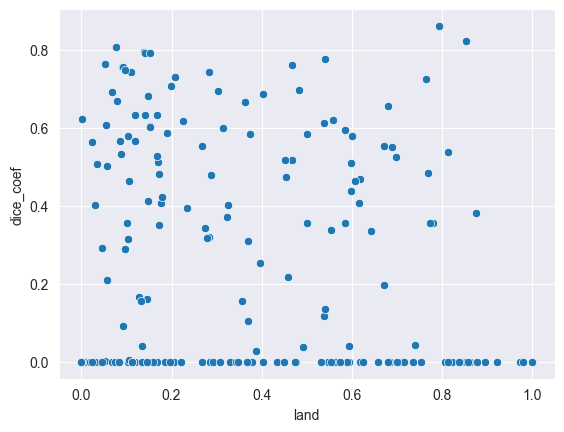

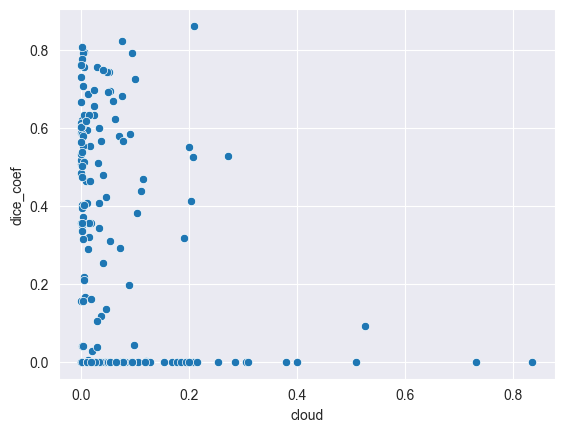

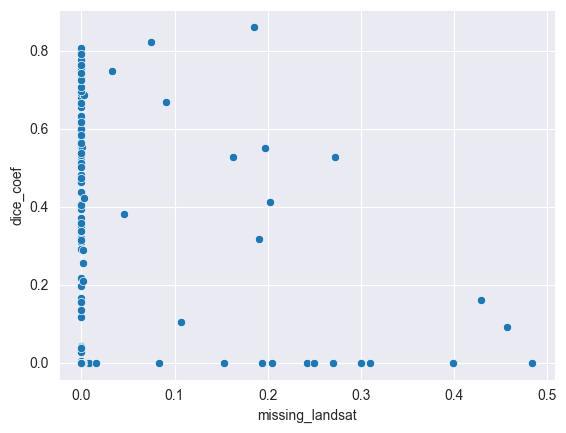

In [16]:
for col in ['error','kelp', 'land', 'cloud', 'missing_landsat']:
    sns.scatterplot(data=results, x=col, y='dice_coef')
    plt.show()

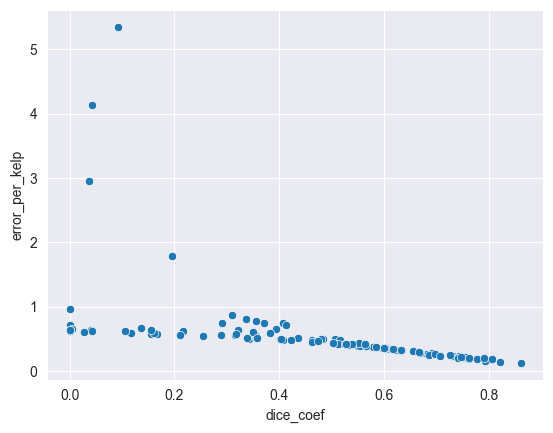

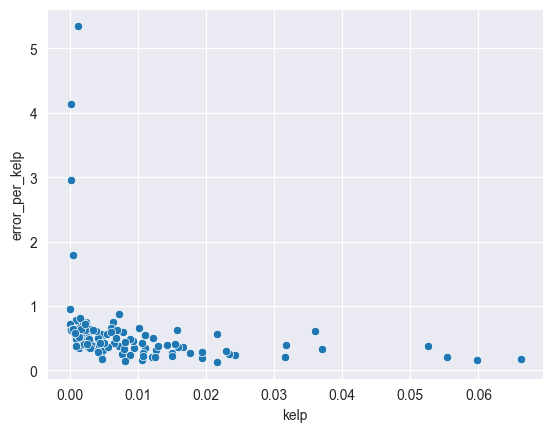

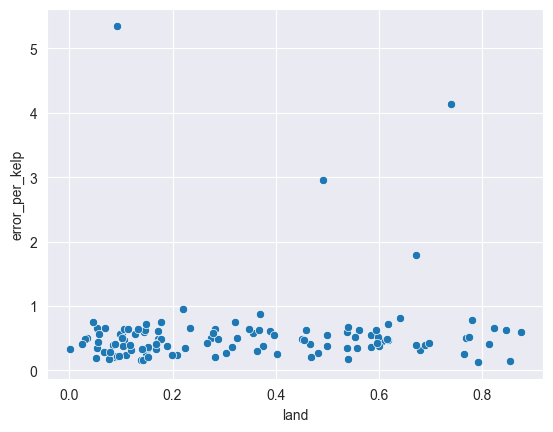

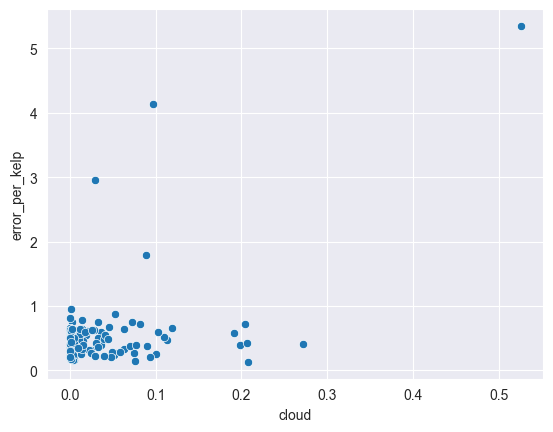

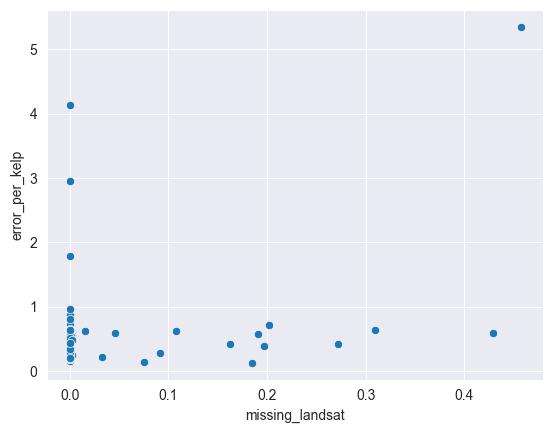

In [17]:
# There is a clear correlation between error and kelp. 
# Create a new column that is the error divided by kelp
# Then make the plots against error again
results['error_per_kelp'] = results['error'] / results['kelp']


# remove outliers with an error_per_kelp larger than n stds
n = 2
results_clean = results[results['kelp'] > 0]
mean = results_clean['error_per_kelp'].mean()
stds = results_clean['error_per_kelp'].std()
results_clean = results_clean[results_clean['error_per_kelp'] < mean + n*stds]


for col in ['dice_coef','kelp', 'land', 'cloud', 'missing_landsat']:
    
    sns.scatterplot(data=results_clean, x=col, y='error_per_kelp')
    plt.show()